In [136]:
import os
from IPython import display
from matplotlib import pyplot as plt
import rasterio
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import sklearn
import math
import time
from zipfile import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, accuracy_score

In [98]:
import sys
sys.path.append('../')
from CPR.configs import data_path
from CPR.utils import tif_stacker, cloud_generator, preprocessing, train_val

In [237]:
import importlib
importlib.reload(CPR.utils)

<module 'CPR.utils' from '..\\CPR\\utils.py'>

In [9]:
# Order in which features should be stacked to create stacked tif
feat_list_new = ['aspect','curve', 'developed', 'GSW_distExtent', 'elevation', 'forest',
 'GSW_maxExtent', 'hand', 'other_landcover', 'planted', 'slope', 'spi', 'twi', 'wetlands', 'flooded']

img_list = ['4115_LC08_021033_20131227_test']

for j, img in enumerate(img_list):
    #  Stack all the flood imagery
    tif_stacker(data_path, img, feat_list_new, overwrite=False)
    cloud_generator(img, data_path, overwrite=False)


"stack.tif" already exists for 4115_LC08_021033_20131227_test
Cloud image already exists for 4115_LC08_021033_20131227_test


In [140]:
pctl = [20]
data_train, data_vector_train, data_ind_train = preprocessing(data_path, img, pctl, gaps=False)
# training_data, validation_data = train_val(data_vector, holdout=0.3)

## Training NN with MC Dropout 

In [225]:
X_train, y_train = training_data[:,0:14], training_data[:,14]
X_val, y_val = validation_data[:,0:14], validation_data[:,14]

pctl = 20
INPUT_DIMS = X_train.shape[1:]
INPUT_SIZE = X_train.shape[0]
BATCH_SIZE = 1000
EPOCHS = 1
DROPOUT_RATE = 0.3
HOLDOUT = 0.3

In [228]:
# def get_NN_MCD():
#     inputs = tf.keras.layers.Input(shape=(input_dims,))
#     x = tf.keras.layers.Dropout(rate=dropout_rate)(inputs, training=True)
#     x = tf.keras.layers.Dense(units=29, activation='relu')(x)
#     x = tf.keras.layers.Dropout(rate=dropout_rate)(x, training=True)  
#     x = tf.keras.layers.Dense(units=15, activation='relu')(x)
#     outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
#     model = tf.keras.Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',      
# #                   metrics=[tf.keras.metrics.Recall()])
# #                   metrics=[tf.keras.metrics.F1()])
#                   metrics=['sparse_categorical_accuracy'])
#     return model

def get_NN_MCD():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=INPUT_DIMS)),
    model.add(tf.keras.layers.Lambda(lambda x: K.dropout(x, level=DROPOUT_RATE))),
    model.add(tf.keras.layers.Dense(units=29,
                                    activation='relu')),
    model.add(tf.keras.layers.Lambda(lambda x: K.dropout(x, level=DROPOUT_RATE))),
    model.add(tf.keras.layers.Dense(units=15,
                                    activation='relu')),
#     model.add(tf.keras.layers.Dropout(rate=dropout_rate)(training=True)),
#     model.add(tf.keras.layers.Flatten()),
    model.add(tf.keras.layers.Dense(2,
                                    activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',      
#                   metrics=[tf.keras.metrics.Recall()])
#                   metrics=[tf.keras.metrics.F1()])
                  metrics=['sparse_categorical_accuracy'])
    return model

# Can maybe use callbacks to get output? https://keras.io/callbacks/

NN_MCD = get_NN_MCD()
NN_MCD.summary()
NN_MCD.fit(X_train, y_train,
           batch_size = BATCH_SIZE,
           epochs= EPOCHS,
           verbose = 1,
           validation_data = (X_val, y_val),
           use_multiprocessing = True)
model_path = data_path / 'models' / 'cnn_vary_clouds' / img / '{0}'.format(img+'_clouds_'+str(pctl)+'.h5')
NN_MCD.save(model_path)
new_model = tf.keras.models.load_model(model_path)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_52 (Lambda)           (None, 14)                0         
_________________________________________________________________
dense_104 (Dense)            (None, 29)                435       
_________________________________________________________________
lambda_53 (Lambda)           (None, 29)                0         
_________________________________________________________________
dense_105 (Dense)            (None, 15)                450       
_________________________________________________________________
dense_106 (Dense)            (None, 2)                 32        
Total params: 917
Trainable params: 917
Non-trainable params: 0
_________________________________________________________________
Train on 221269 samples, validate on 94829 samples
221269/221269 [==============================] - 3s 13us/sample - loss

ValueError: You are trying to load a weight file containing 3 layers into a model with 0 layers.

In [233]:
NN_MCD = get_NN_MCD()
NN_MCD.load_weights(str(model_path))

In [234]:
pctl = [20]
data_gaps, data_vector_gaps, data_ind_gaps = preprocessing(data_path, img, pctl, gaps=True)

X_test, y_test = data_vector_gaps[:,0:14], data_vector_gaps[:,14]
NN_MCD.predict(X_test)

array([[9.8907322e-01, 1.0926717e-02],
       [9.9481624e-01, 5.1837093e-03],
       [9.9997187e-01, 2.8109633e-05],
       ...,
       [9.6121907e-01, 3.8780913e-02],
       [9.8164141e-01, 1.8358627e-02],
       [9.7567934e-01, 2.4320718e-02]], dtype=float32)

In [229]:
import json
import h5py

def fix_layer0(filename, batch_input_shape, dtype):
    with h5py.File(filename, 'r+') as f:
        model_config = json.loads(f.attrs['model_config'].decode('utf-8'))
        layer0 = model_config['config'][0]['config']
        layer0['batch_input_shape'] = batch_input_shape
        layer0['dtype'] = dtype
        f.attrs['model_config'] = json.dumps(model_config).encode('utf-8')

# Example
fix_layer0(model_path, INPUT_DIMS, 'float32')
# fix_layer0(model_path, [None, 64, 64], 'float32')

KeyError: 0

## Testing NN on cloud gaps

In [107]:
pctl = [20]
data_gaps, data_vector_gaps, data_ind_gaps = preprocessing(data_path, img, pctl, gaps=True)

X_test, y_test = data_vector_gaps[:,0:14], data_vector_gaps[:,14]

def predict_with_uncertainty(model, X):
    preds = []
    for i in range(mc_passes):
        preds.append(model.predict(X))
    preds = np.array(preds)
    means = np.mean(preds, axis=0)
    variances = np.var(preds, axis=0)
    stds = np.std(preds, axis=0)
    pred = np.argmax(means, axis=1)
    
#     return pred, preds, means, variances, stds
    return pred, variances

mc_passes = 100
# pred, preds, means, variances, stds = predict_with_uncertainty(NN_MCD, X_test)
pred, variances = predict_with_uncertainty(NN_MCD, X_test)

In [ ]:
# Plotting how many MC samples predicted flooding?
# (# times the prob of flooding > 0.5) / # samples
# The color bar should be more saturated in the middle to highlight greater
# uncertainty, and lighter towards 0% and 100%.

# flood = 0
# flood += 

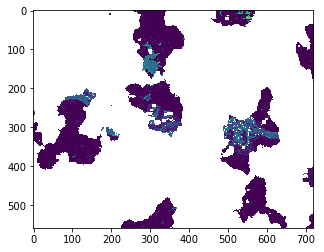

In [126]:
# Reshape gaps back into image
stack_path = data_path / 'images' / img / 'stack' / 'stack.tif'
with rasterio.open(str(stack_path), 'r') as ds:
        shape = ds.read(1).shape # Shape of full original image
        arr_empty = np.zeros(shape) # Create empty array with this shape
        arr_empty[:] = np.nan # Convert all zeroes to NaN
        var_img = arr_empty
        rows, cols = zip(data_ind_gaps)
        var_img[rows, cols] = variances[:,0]
plt.imshow(var_img)

## Training on multiple cloud covers

In [239]:
import sys
sys.path.append('../')
from CPR.configs import data_path
from CPR.utils import tif_stacker, cloud_generator, preprocessing, train_val, timer

# Order in which features should be stacked to create stacked tif
feat_list_new = ['aspect','curve', 'developed', 'GSW_distExtent', 'elevation', 'forest',
 'GSW_maxExtent', 'hand', 'other_landcover', 'planted', 'slope', 'spi', 'twi', 'wetlands', 'flooded']

# Image to predict on
img_list = ['4115_LC08_021033_20131227_test']
# img_list = ['4101_LC08_027038_20131103_1', 
#             '4101_LC08_027038_20131103_2', 
#             '4101_LC08_027039_20131103_1',
#             '4115_LC08_021033_20131227_1',
#             '4337_LC08_026038_20160325_1']

# pctls = [10,20,30,40,50,60,70,80,90]
pctls = [80, 90]
batch_size = 1000
epochs = 10
dropout_rate = 0.3
holdout = 0.3 # Validation data size

valMetricsList = []

# Stack layers into a single tif, and generate cloud cover image
for j, img in enumerate(img_list):
    precision = []
    recall = []
    f1 = []
    accuracy = []
    times = []
    history = []
    
    tif_stacker(data_path, img, feat_list_new, overwrite=False)
    cloud_generator(img, data_path, overwrite=False)
    
    for i, pctl in enumerate(pctls):
        data_train, data_vector_train, data_ind_train = preprocessing(data_path, img, pctl, gaps=False)
        training_data, validation_data = train_val(data_vector_train, holdout=holdout)
        X_train, y_train = training_data[:,0:14], training_data[:,14]
        X_val, y_val = validation_data[:,0:14], validation_data[:,14]
        INPUT_DIMS = X_train.shape[1]
                           
        print(img)
        start_time = time.time()
        NN_MCD = get_NN_MCD()

        NN_MCD.fit(X_train, y_train,
                   batch_size = batch_size,
                   epochs= epochs,
                   verbose = 1,
                   validation_data = (X_val, y_val),
                   use_multiprocessing = True)
        
        model_path = data_path / 'models' / 'cnn_vary_clouds' / img / '{0}'.format(img+'_clouds_'+str(pctl)+'.h5')
        NN_MCD.save(model_path)


"stack.tif" already exists for 4115_LC08_021033_20131227_test
Cloud image already exists for 4115_LC08_021033_20131227_test
4115_LC08_021033_20131227_test
Train on 55904 samples, validate on 23958 samples
Epoch 1/10
55904/55904 [==============================] - 1s 25us/sample - loss: 0.3227 - sparse_categorical_accuracy: 0.9512 - val_loss: 0.1600 - val_sparse_categorical_accuracy: 0.9960
Epoch 2/10
55904/55904 [==============================] - 0s 9us/sample - loss: 0.1333 - sparse_categorical_accuracy: 0.9822 - val_loss: 0.0649 - val_sparse_categorical_accuracy: 0.9968
Epoch 3/10
55904/55904 [==============================] - 1s 9us/sample - loss: 0.0906 - sparse_categorical_accuracy: 0.9832 - val_loss: 0.0386 - val_sparse_categorical_accuracy: 0.9973
Epoch 4/10
55904/55904 [==============================] - 1s 10us/sample - loss: 0.0743 - sparse_categorical_accuracy: 0.9841 - val_loss: 0.0304 - val_sparse_categorical_accuracy: 0.9973
Epoch 5/10
55904/55904 [=========================

In [ ]:
# There is a problem loading keras models: https://github.com/keras-team/keras/issues/10417
# But loading the weights into another compiled model works
def predict_with_uncertainty(model, X):
    preds = []
    for i in range(mc_passes):
        preds.append(model.predict(X))
    preds = np.array(preds)
    means = np.mean(preds, axis=0)
    variances = np.var(preds, axis=0)
    stds = np.std(preds, axis=0)
    pred = np.argmax(means, axis=1)
    
#     return pred, preds, means, variances, stds
    return pred, variances

NN_MCD = get_NN_MCD()
model_path = data_path / 'models' / 'cnn_vary_clouds' / img / '{0}'.format(img+'_clouds_'+str(pctl)+'.h5')
NN_MCD.load_weights(str(model_path))

mc_passes = 100
# pred, preds, means, variances, stds = predict_with_uncertainty(NN_MCD, X_test)
pred, variances = predict_with_uncertainty(NN_MCD, X_test)